# Contacts Analysis #

In [43]:
import MDAnalysis
import MDAnalysis.analysis.distances
from MDAnalysis import transformations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import utils_mda.seq_manipulation as seq_manipulation
from importlib import reload
reload(seq_manipulation)

from MDAnalysis.analysis import leaflet
plt.style.use('default')


In [53]:
def get_combinations(u, peptide, pep_num, pairs=None):
    """
    Get list of residue residue combinations

    Input: 
        peptide: list of strin
            list of peptides
        pepnum: int 
            number of peptides of each type
        pairs: 
    """
    _, new_dict = seq_manipulation.get_aa_sequence(u, peptide, pep_num)
    peptide_ranges = seq_manipulation.get_peptide_range(peptide, list(new_dict.keys())[0], pep_num)
    
    comb_list = []
    for i in peptide_ranges.keys():
        for j in peptide_ranges.keys():
            comb_list.extend([(x, y) for x in peptide_ranges[i] for y in peptide_ranges[j] if (y, x) not in comb_list])
    if pairs:
        comb_list.extend([(x, y) for x in peptide_ranges[i] for y in peptide_ranges[j] if (y, x) not in comb_list])
    return list(set(comb_list))

p="/Volumes/miru_backup/jade_2synergy/popg_replicas/WF1a_WF2_pg_2"
# p=f"/Volumes/miru_backup/jade_2synergy/popg/{pep}_pg"
# p = f"/Volumes/miru_backup/synergy_in_membrane/popg/{pep}_pg"
u = seq_manipulation.get_universe(p, "md_0_1_combined", "md_0_1")
workflow = [transformations.unwrap(u.atoms)]
u.trajectory.add_transformations(*workflow)
x = get_combinations(u, [l for l in "WF1a_WF2".split("_")], 4)

FOUND xtc
found U
peptides_list is  ['WF1a', 'WF1a', 'WF1a', 'WF1a', 'WF2', 'WF2', 'WF2', 'WF2']
peptides_list is  ['WF1a', 'WF1a', 'WF1a', 'WF1a', 'WF2', 'WF2', 'WF2', 'WF2']


In [61]:
def distance_matrix_time(u, peptide, pep_num):
    print("pep num is ", pep_num)
    # seq_manipulation.check_peptides(u, peptide)
    step_size = 50
    start, stop, step = u.trajectory.check_slice_indices(None, None, None)


    frames = np.arange(start, stop, step_size)

    n_frames = frames.size

    #works same as nested loop
    mindist_matrix_all_peptide = {}
    combinations = get_combinations(u, peptide, pep_num)
    
    new_mindist = {
        f"{c[0]}:{c[1]}":[] for c in combinations
    }
    df_list = []
    for frame_index, ts in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
        #Loop through permutations, create 2D array with amino acid and minimum distance
        mindist_matrix_all_peptide["peptide"] = []
        for c in combinations:
            selection1 = u.select_atoms('resid %s'%c[0]).positions
            selection2 = u.select_atoms('resid %s'%c[1]).positions
            dist = MDAnalysis.analysis.distances.distance_array(selection1, selection2, 
                                                                box=u.dimensions, result=None, backend='serial')
            min_dist = np.min(dist)
            new_mindist[f"{c[0]}:{c[1]}"].append(min_dist)
        new_matrix = [[int(k.split(":")[0]), int(k.split(":")[1]), v, ts] for k,v in new_mindist.items()]
        df = pd.DataFrame(new_matrix, columns=['Peptide1','Peptide2', 'mindist', "Time(ns)"])

        df_list.append(df)
    return df_list
membrane = "pg"
for pep in ["WF1a_WF2"]:
    p="/Volumes/miru_backup/jade_2synergy/popg_replicas/WF1a_WF2_pg_2"

    u = seq_manipulation.get_universe(p, "md_0_1_combined", "md_0_1")
    workflow = [transformations.unwrap(u.atoms)]
    u.trajectory.add_transformations(*workflow)
    df_list = distance_matrix_time(u, [l for l in pep.split("_")], 4)

FOUND xtc
found U
pep num is  4
peptides_list is  ['WF1a', 'WF1a', 'WF1a', 'WF1a', 'WF2', 'WF2', 'WF2', 'WF2']
peptides_list is  ['WF1a', 'WF1a', 'WF1a', 'WF1a', 'WF2', 'WF2', 'WF2', 'WF2']


  0%|          | 2/1001 [01:16<10:35:46, 38.18s/it]

In [39]:
df_list.to_csv("distance_over_time_WF1a_WF2_pg.csv")
pd_concat = pd.read_csv("distance_over_time_WF1a_WF2_pg.csv")
pd_concat = pd_concat.drop(columns=["Unnamed: 0"])
pd_concat
len(set(pd_concat["Time(ns)"].tolist()))

51

<Axes: title={'center': 'Min distance over time -  pep5 - pep1 '}, xlabel='Time(ns)'>

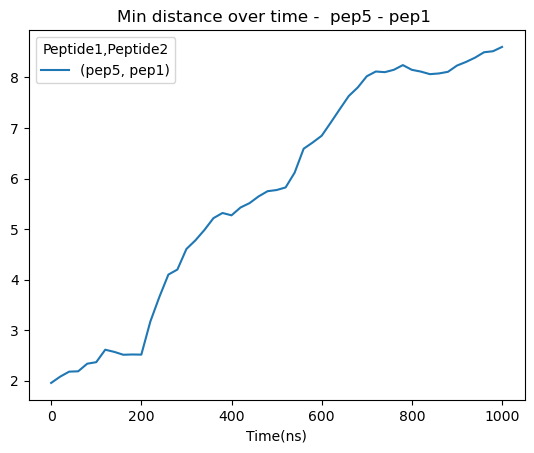

In [21]:
pep1 = "pep5"
pep2 = "pep1"
pd_in_contact = pd_concat[pd_concat["Peptide1"]==pep1]
pd_in_contact = pd_in_contact[pd_in_contact["Peptide2"]==pep2]
df3 = pd_in_contact.groupby(["Peptide1", "Peptide2", "Time(ns)"])["mindist"].min().unstack(-1)
df3.T.plot(title=f"Min distance over time -  {pep1} - {pep2} ")

In [22]:
peptide_list = list(set(pd_concat["Peptide1"]))
from itertools import combinations
combinations_list = list(set(combinations(peptide_list, 2)))
combinations_list = [f"{p[0]}_{p[1]}" for p in combinations_list]
combinations_list

['pep7_pep6',
 'pep3_pep7',
 'pep8_pep1',
 'pep8_pep3',
 'pep3_pep6',
 'pep2_pep8',
 'pep2_pep1',
 'pep4_pep1',
 'pep5_pep7',
 'pep2_pep3',
 'pep3_pep5',
 'pep5_pep6',
 'pep8_pep7',
 'pep3_pep4',
 'pep1_pep6',
 'pep4_pep7',
 'pep8_pep6',
 'pep2_pep7',
 'pep7_pep1',
 'pep3_pep1',
 'pep5_pep4',
 'pep4_pep6',
 'pep8_pep5',
 'pep2_pep6',
 'pep8_pep4',
 'pep2_pep5',
 'pep5_pep1',
 'pep2_pep4']

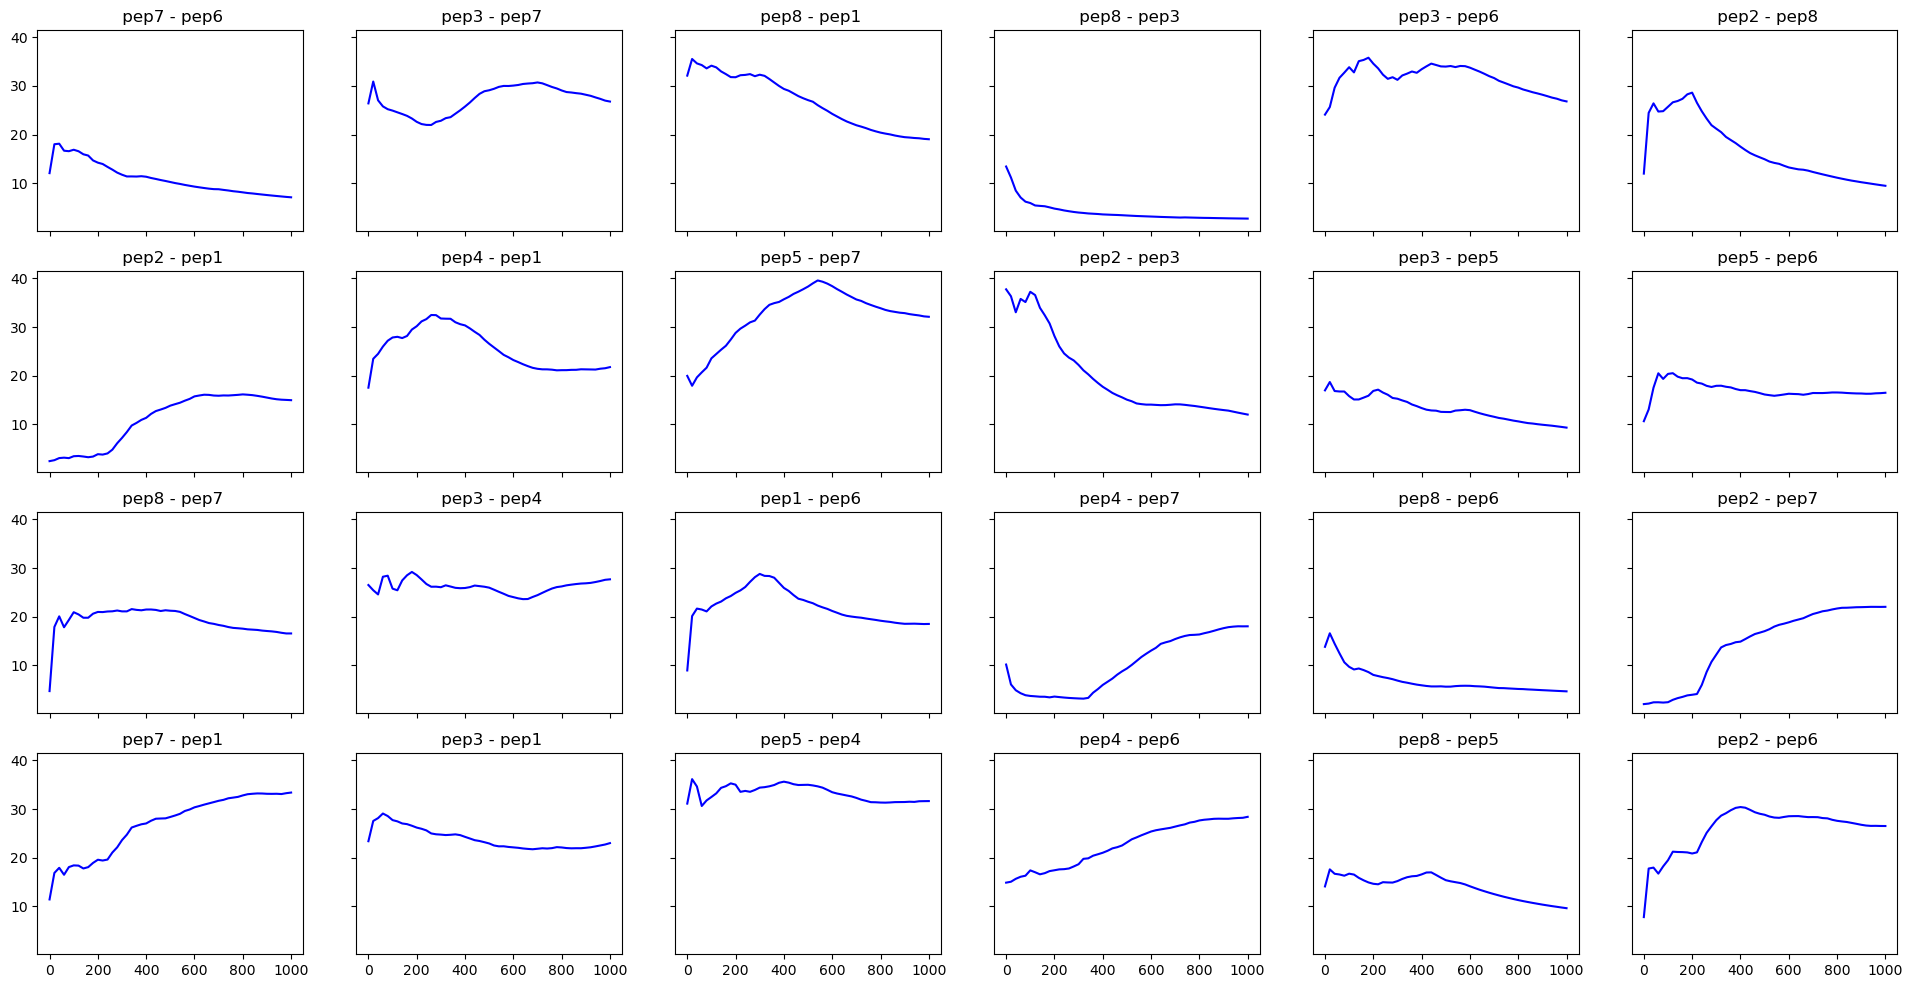

In [23]:
from itertools import combinations

fig, axs = plt.subplots(4, 6, figsize=(24, 12), sharey=True, sharex=True)



for pep_pair, ax in zip(list(set(combinations(peptide_list, 2))), axs.ravel()):
    pep1 = pep_pair[0]
    pep2 = pep_pair[1]
    pd_in_contact = pd_concat[pd_concat["Peptide1"]==pep1]
    pd_in_contact = pd_in_contact[pd_in_contact["Peptide2"]==pep2]
    df3 = pd_in_contact.groupby(["Peptide1", "Peptide2", "Time(ns)"])["mindist"].min().unstack(-1)
    ax.plot(df3.T, c='b')
    ax.set_title(f" {pep1} - {pep2}")
plt.savefig("WF1a_WF2_replica_contacts_min_distance_popg")


In [34]:
df_interactions = pd_concat
df_interactions["Peptide_Pair"] = df_interactions["Peptide1"] + "_" +   df_interactions["Peptide2"]
df_interactions = df_interactions[df_interactions["Peptide_Pair"].isin(combinations_list)]
# df_interactions = df_interactions.groupby(["Peptide_Pair", "Time(ns)"])["mindist"].min().unstack(-1)
# df_interactions = df_interactions.mask(df_interactions>7, 8)
# df_interactions
len(set(df_interactions["Time(ns)"].tolist()))

51

<Axes: xlabel='Time(ns)', ylabel='Peptide_Pair'>

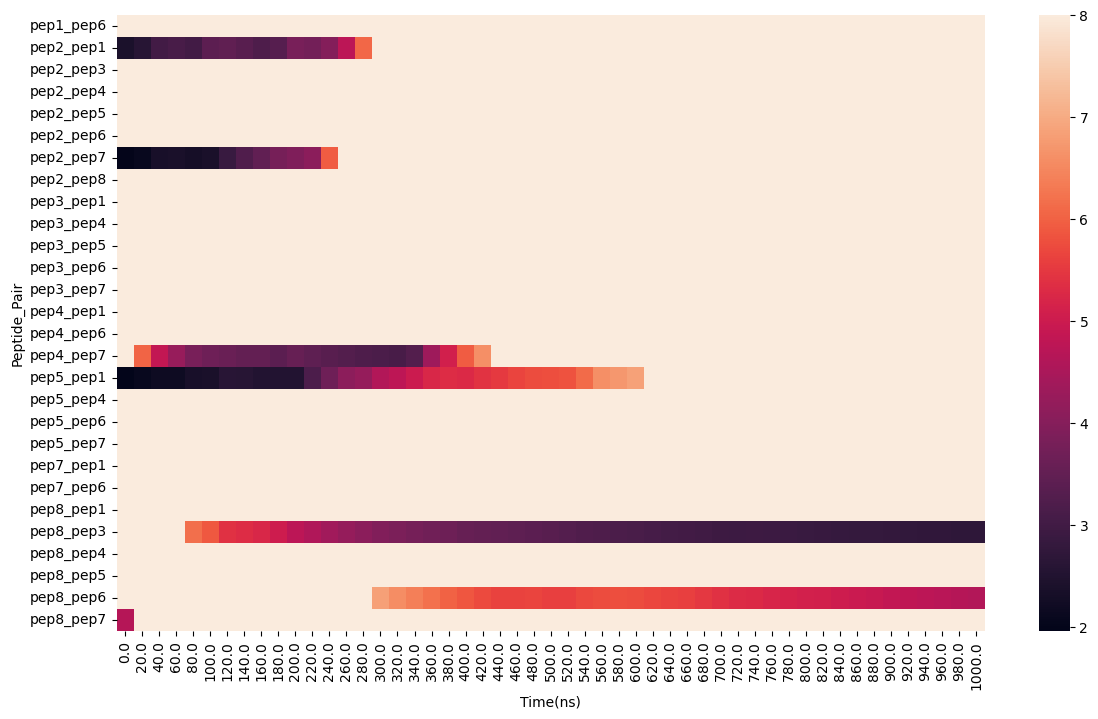

In [14]:
plt.figure(figsize=(14, 8))

sns.heatmap(df_interactions, xticklabels=True, yticklabels=True)


In [15]:
df_interactions_to_save = df_interactions.mask(df_interactions>7, 0)
df_interactions_to_save = df_interactions_to_save.mask(df_interactions_to_save>0, 1)
df_interactions_to_save.to_csv("WF1a_WF2_interactions_true_false.csv")

In [16]:
df_interactions_to_save

Time(ns),0.0,20.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,180.0,...,820.0,840.0,860.0,880.0,900.0,920.0,940.0,960.0,980.0,1000.0
Peptide_Pair,,,,,,,,,,,,,,,,,,,,,
pep1_pep6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep2_pep8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pep3_pep1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
